## 1. Importer les bibliothèques

In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

## 2. Importer les ensembles de données

Toutes nos données dans ce rapport sont dérivées de sources publiquement disponibles, principalement des bases de données de la Banque mondiale et de la FAO. Nous avons décidé de nous concentrer sur l'année 2022 pour notre analyse car c'est l'année la plus récente avec des données complètes disponibles pour plusieurs indicateurs.

In [ ]:
def load_world_bank_data(file_path, column_name, skiprows=4):
    """Charger les données de l'API Banque mondiale avec un motif cohérent"""
    return (pd.read_csv(file_path, skiprows=skiprows)[['Country Code', '2022']]
            .rename(columns={'2022': column_name})
            .dropna())

def process_trade_data(df, element_type):
    """Traiter les données d'importation ou d'exportation"""
    df = df[df['Element'] == f'{element_type} quantity'].copy()
    df.rename(columns={'Value': f'{element_type} Quantity (t)'}, inplace=True)
    df[f'{element_type} Quantity (kg)'] = df[f'{element_type} Quantity (t)'] * 1000
    df = df.drop(columns=[f'{element_type} Quantity (t)', 'Element'])
    return df.dropna()

In [ ]:
## Chargement des ensembles de données de la Banque mondiale
# Définir tous les ensembles de données de la Banque mondiale
wb_datasets = {
    'Access to Electricity (%)': 'data/access to electricity/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_1058634.csv',
    'Population Growth Rate': 'data/population growth/API_SP.POP.GROW_DS2_en_csv_v2_1058428.csv',
    'Urban Population Growth Rate': 'data/ubranization growth/API_SP.URB.GROW_DS2_en_csv_v2_1044859.csv',
    'Urban Population': 'data/urban population/API_SP.URB.TOTL_DS2_en_csv_v2_1209517.csv',
    'Political Stability Index': 'data/political stability index/API_PV.EST_DS2_en_csv_v2_1023320.csv',
    'Regulatory Quality Index': 'data/regulatory quality/API_RQ.EST_DS2_en_csv_v2_1059205.csv',
    'Logistics Performance Index': 'data/logistics index/API_LP.LPI.OVRL.XQ_DS2_en_csv_v2_948643.csv',
    'GDP per Capita Growth (%)': 'data/gdp per capita growth/API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_1057933.csv',
}

# Charger tous les ensembles de données de la Banque mondiale à la fois
wb_dataframes = {name: load_world_bank_data(path, name) for name, path in wb_datasets.items()}

print(f"Chargé {len(wb_dataframes)} ensembles de données de la Banque mondiale")

Loaded 8 World Bank datasets


In [ ]:
## Chargement du PIB par habitant

df_gdp_per_capita = load_world_bank_data(
    'data/GDP per capita/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_904059.csv',
    'GDP per Capita (current US$)',
    skiprows=0
)
print(f"Forme du PIB par habitant: {df_gdp_per_capita.shape}")
df_gdp_per_capita.head()

GDP per Capita shape: (257, 2)


,Country Code,GDP per Capita (current US$)
0,ABW,30559.533535
1,AFE,1628.318944
2,AFG,357.261153
3,AFW,1796.668633
4,AGO,2929.694455


In [ ]:
## Chargement de la population totale

df_total_pop = (pd.read_csv('data/world population/API_SP.POP.TOTL_DS2_en_csv_v2_943813.csv')
                [['Country Name', 'Country Code', '2022']]
                .rename(columns={'2022': 'Total Population'})
                .dropna())
print(f"Forme de la population totale: {df_total_pop.shape}")
df_total_pop.head()

Total Population shape: (265, 3)


,Country Name,Country Code,Total Population
0,Aruba,ABW,107310.0
1,Africa Eastern and Southern,AFE,731821393.0
2,Afghanistan,AFG,40578842.0
3,Africa Western and Central,AFW,497387180.0
4,Angola,AGO,35635029.0


In [ ]:
## Chargement des données de production de poulet

df_production = (pd.read_csv('data/chicken-meat-production/chicken-meat-production.csv')
                 .query('Year == 2022')
                 .rename(columns={
                     'Meat, chicken | 00001058 || Production | 005510 || tonnes': 'Chicken Meat Production (tonnes)',
                     'Code': 'Country Code'
                 })
                 .drop(columns=['Year', 'Entity']))

df_production['Chicken Meat Production (kg)'] = df_production['Chicken Meat Production (tonnes)'] * 1000
df_production = df_production.drop(columns=['Chicken Meat Production (tonnes)']).dropna()

print(f"Forme de la production: {df_production.shape}")
df_production.head()

Production shape: (197, 2)


,Country Code,Chicken Meat Production (kg)
61,AFG,28503140.0
250,ALB,16335570.0
313,DZA,407744300.0
439,AGO,57177380.0
502,ATG,88310.0


In [ ]:
## Chargement des données de consommation de viande

df_meat_consumption = (pd.read_csv('data/per-capita-meat-consumption-by-type-kilograms-per-year/per-capita-meat-consumption-by-type-kilograms-per-year.csv')
                       .query('Year == 2022')
                       [['Code', 'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita']]
                       .rename(columns={
                           'Code': 'Country Code',
                           'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita': 'Poultry Consumption (kg/capita)'
                       })
                       .dropna())

print(f"Forme de la consommation de viande: {df_meat_consumption.shape}")
df_meat_consumption.head()

Meat Consumption shape: (189, 2)


,Country Code,Poultry Consumption (kg/capita)
61,AFG,0.881790
247,ALB,22.677332
309,DZA,6.052606
433,AGO,10.506409
495,ATG,68.999690


In [ ]:
## Chargement du mappage des codes de pays M49

df_m49 = (pd.read_csv('data/2022-09-24__CSV_UNSD_M49.csv', 
                      sep=None, 
                      engine='python',
                      usecols=['Country or Area', 'M49 Code', 'ISO-alpha3 Code']))
print(f"Forme M49: {df_m49.shape}")
df_m49.head()

## Chargement et traitement des données d'importation/exportation

df_import_export = (pd.read_csv('data/import export of dead and live chicken /FAOSTAT_data_en_10-3-2025.csv')
                    .drop(columns=['Area', 'Year', 'Year Code', 'Item Code (CPC)', 
                                   'Element Code', 'Flag', 'Flag Description', 
                                   'Note', 'Domain Code', 'Domain', 'Item'])
                    .merge(df_m49, left_on='Area Code (M49)', right_on='M49 Code', how='left')
                    .drop(columns=['Area Code (M49)', 'Unit', 'Country or Area', 'M49 Code'])
                    .rename(columns={'ISO-alpha3 Code': 'Country Code'}))

# Traiter les données d'importation et d'exportation
df_import = process_trade_data(df_import_export, 'Import')
df_export = process_trade_data(df_import_export, 'Export')

print(f"Forme de l'importation: {df_import.shape}")
print(f"Forme de l'exportation: {df_export.shape}")

print("\nDonnées d'importation:")
display(df_import.head())

print("\nDonnées d'exportation:")
display(df_export.head())

M49 shape: (249, 3)
Import shape: (187, 2)
Export shape: (133, 2)

Import data:

Import shape: (187, 2)
Export shape: (133, 2)

Import data:


,Country Code,Import Quantity (kg)
0,AFG,6902310.0
4,ALB,43124460.0
8,AGO,308122710.0
12,ATG,6406990.0
16,ARG,10218320.0



Export data:


,Country Code,Export Quantity (kg)
2,AFG,56040.0
6,DZA,29000.0
10,AGO,10870.0
14,ATG,5840.0
18,ARG,179621830.0


## 3. Fusion de toutes les données

In [36]:
df_all = df_total_pop.copy()

# Merge World Bank datasets
for name, df in wb_dataframes.items():
    df_all = df_all.merge(df, on='Country Code', how='left')
    
# Merge remaining datasets
additional_datasets = [
    df_gdp_per_capita,
    df_meat_consumption,
    df_production,
    df_import,
    df_export
]

for df in additional_datasets:
    df_all = df_all.merge(df, on='Country Code', how='left')

print(f"Combined data shape before cleaning: {df_all.shape}")
df_all.head()

Combined data shape before cleaning: (265, 16)


,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Poultry Consumption (kg/capita),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg)
0,Aruba,ABW,107310.0,99.900000,-0.362774,0.059249,47272.0,1.483080,0.967043,NaN,8.912308,30559.533535,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,731821393.0,48.801258,2.592754,3.961598,277426261.0,NaN,NaN,2.618182,0.905330,1628.318944,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,40578842.0,85.300000,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.900000,-7.576669,357.261153,0.881790,28503140.0,6902310.0,56040.0
3,Africa Western and Central,AFW,497387180.0,55.686683,2.332270,3.556585,244365364.0,NaN,NaN,2.473333,1.578046,1796.668633,NaN,NaN,NaN,NaN
4,Angola,AGO,35635029.0,48.500000,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.100000,-0.143628,2929.694455,10.506409,57177380.0,308122710.0,10870.0


## 4. Nettoyage des données & ingénierie des caractéristiques

Nous souhaitons exclure la France de notre analyse et supprimer toutes les lignes avec des valeurs manquantes.

In [ ]:
df_all = df_all.dropna().reset_index(drop=True)
df_all = df_all[df_all['Country Code'] != 'FRA']
print(f"Forme finale des données après suppression des NaN et exclusion de la France: {df_all.shape}")
df_all

Final data shape after removing NaN & excluded france: (104, 16)


,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Poultry Consumption (kg/capita),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg)
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,0.881790,2.850314e+07,6902310.0,5.604000e+04
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,10.506409,5.717738e+07,308122710.0,1.087000e+04
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,50.929320,4.700000e+07,615447940.0,9.400743e+07
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,48.298690,2.319469e+09,10218320.0,1.796218e+08
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,17.806946,1.410000e+07,37595230.0,1.928000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Uruguay,URY,3390913.0,100.0,-0.170369,-0.081484,3244697.0,1.085830,0.713579,3.0,4.664391,20818.614609,23.882421,7.972700e+07,5325130.0,1.075050e+06
101,United States,USA,334017321.0,100.0,0.575745,0.830027,277514951.0,0.008701,1.424440,3.8,1.923862,77860.911291,53.031433,1.984124e+10,80798320.0,3.745962e+09
102,Uzbekistan,UZB,34938955.0,100.0,2.009991,2.087298,17632293.0,-0.201336,-0.550315,2.6,3.891995,2578.666894,6.323154,1.488000e+08,50737420.0,3.457300e+05
103,Viet Nam,VNM,99680655.0,100.0,0.750757,2.609752,38642203.0,-0.046132,-0.429956,3.3,7.725699,4147.697772,14.725962,1.363790e+09,267072320.0,2.649000e+06


In [38]:
df_all.columns

Index(['Country Name', 'Country Code', 'Total Population',
       'Access to Electricity (%)', 'Population Growth Rate',
       'Urban Population Growth Rate', 'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index', 'GDP per Capita Growth (%)',
       'GDP per Capita (current US$)', 'Poultry Consumption (kg/capita)',
       'Chicken Meat Production (kg)', 'Import Quantity (kg)',
       'Export Quantity (kg)'],
      dtype='object')

In [ ]:
# Calculer la consommation totale de volaille et supprimer la colonne par habitant
df_all['Poultry Consumption (kg)'] = df_all['Poultry Consumption (kg/capita)'] * df_all['Total Population']
df_all = df_all.drop(columns=['Poultry Consumption (kg/capita)'])

print(f"Forme finale des données: {df_all.shape}")


# Ingénierie des caractéristiques
# RD = importations x 100/(production + importations - exportations)
df_all['Import Dependency Ratio'] = (df_all['Import Quantity (kg)'] * 100) / (df_all['Chicken Meat Production (kg)'] + df_all['Import Quantity (kg)'] - df_all['Export Quantity (kg)'])

# TAA = production × 100/(production + importations - exportations)
df_all['Self-Sufficiency Ratio'] = (df_all['Chicken Meat Production (kg)']*100) / (df_all['Chicken Meat Production (kg)'] + df_all['Import Quantity (kg)'] - df_all['Export Quantity (kg)'])

# Potentiel de croissance de la consommation de volaille
df_all['Poultry Consumption Growth Potential'] = df_all['Poultry Consumption (kg)'] * df_all['Urban Population Growth Rate']

df_all.head()

Final data shape: (104, 16)


,Country Name,Country Code,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio,Poultry Consumption Growth Potential
0,Afghanistan,AFG,40578842.0,85.3,1.435704,2.576854,10800465.0,-2.544956,-1.271806,1.9,-7.576669,357.261153,2.850314e+07,6902310.0,56040.0,3.578203e+07,19.525955,80.632576,9.220507e+07
1,Angola,AGO,35635029.0,48.5,3.143026,4.059358,24260684.0,-0.630109,-0.606699,2.1,-0.143628,2929.694455,5.717738e+07,308122710.0,10870.0,3.743962e+08,84.350343,15.652633,1.519808e+09
2,United Arab Emirates,ARE,10074977.0,100.0,5.088342,5.367449,8819937.0,0.744183,1.034781,4.0,2.176083,49899.065298,4.700000e+07,615447940.0,94007430.0,5.131117e+08,108.269543,8.268235,2.754101e+09
3,Argentina,ARG,45407904.0,100.0,0.210809,0.338668,41932837.0,-0.098594,-0.697566,2.8,5.048195,13935.681111,2.319469e+09,10218320.0,179621830.0,2.193142e+09,0.475256,107.878993,7.427477e+08
4,Armenia,ARM,2969200.0,100.0,0.232656,0.456271,1887610.0,-0.740756,-0.019079,2.5,12.338334,6571.974455,1.410000e+07,37595230.0,192800.0,5.287238e+07,72.997002,27.377349,2.412414e+07


In [ ]:
df = df_all.copy()

numeric_cols = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential'
]

# Créer la matrice de caractéristiques
X = df[numeric_cols].copy()

# Gérer les valeurs infinies et les données manquantes
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Suivre les identifiants de pays
ids = df.loc[X.index, ['Country Name', 'Country Code']].copy()

# Normaliser les caractéristiques (important pour Isolation Forest)
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=X.columns, 
    index=X.index
)

# Initialiser Isolation Forest
# contamination=0.05 signifie que nous attendons ~5% de données comme anomalies
iso_forest = IsolationForest(
    contamination=0.05,  # Proportion attendue d'anomalies
    random_state=42,      # Pour la reproductibilité
    n_estimators=100      # Nombre d'arbres (par défaut)
)

# Adapter et prédire
# Retourne 1 pour les inliers, -1 pour les anomalies
outlier_labels = iso_forest.fit_predict(X_scaled)

# Identifier les anomalies
outlier_mask = outlier_labels == -1
outliers = X[outlier_mask]

print(f"Nombre d'anomalies détectées: {outlier_mask.sum()}")
print("\nPays identifiés comme anomalies:")
print(ids[outlier_mask])

# Les scores plus négatifs = plus anormaux
outlier_scores = iso_forest.score_samples(X_scaled)
df_scores = pd.DataFrame({
    'Country': ids['Country Name'],
    'Country Code': ids['Country Code'],
    'Outlier Score': outlier_scores,
    'Is Outlier': outlier_labels == -1
}).sort_values('Outlier Score')

print("\nTop 10 des pays les plus anormaux:")
print(df_scores.head(10))

Number of outliers detected: 6

Countries identified as outliers:
      Country Name Country Code
16          Brazil          BRA
23           China          CHN
51           India          IND
66      Luxembourg          LUX
78     Netherlands          NLD
101  United States          USA

Top 10 most anomalous countries:
                      Country Country Code  Outlier Score  Is Outlier
23                      China          CHN      -0.713912        True
101             United States          USA      -0.712171        True
16                     Brazil          BRA      -0.585799        True
51                      India          IND      -0.551912        True
66                 Luxembourg          LUX      -0.550529        True
78                Netherlands          NLD      -0.544285        True
19   Central African Republic          CAF      -0.543831       False
0                 Afghanistan          AFG      -0.519278       False
59                      Japan          JPN    

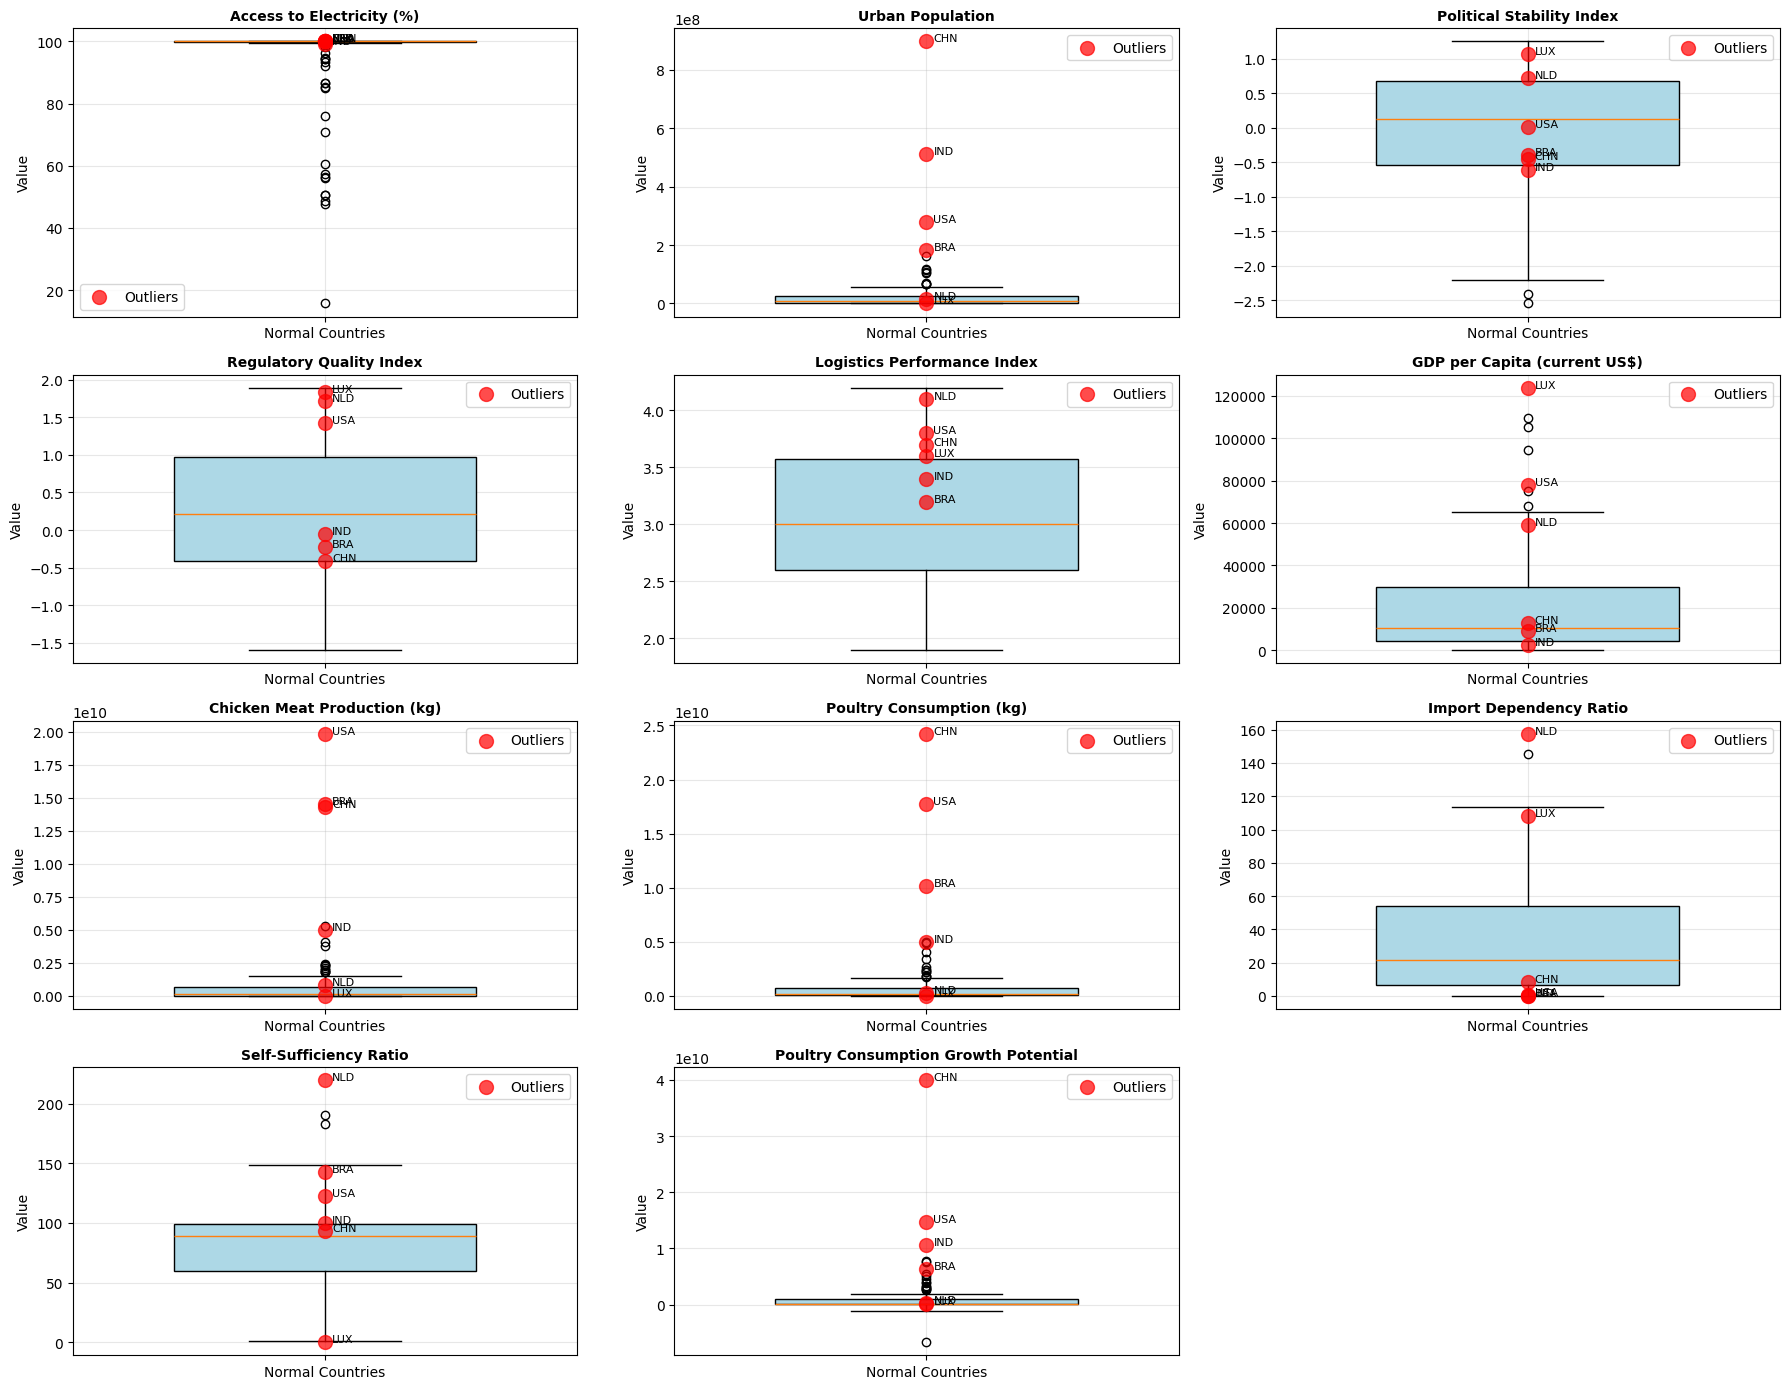

In [ ]:
# Identifier les 6 anomalies
outlier_countries = ['BRA', 'CHN', 'IND', 'LUX', 'NLD', 'USA']

key_features = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential'
]

fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    normal_data = X.loc[outlier_labels == 1, feature]
    outlier_data = X.loc[outlier_labels == -1, feature]
    
    bp = ax.boxplot([normal_data], positions=[1], widths=0.6, 
                     patch_artist=True, labels=['Normal Countries'])
    bp['boxes'][0].set_facecolor('lightblue')
    
    outlier_positions = [1] * len(outlier_data)
    ax.scatter(outlier_positions, outlier_data, color='red', s=100, 
               zorder=3, alpha=0.7, label='Outliers')
    
    for i, (idx_val, val) in enumerate(zip(outlier_data.index, outlier_data)):
        country_code = ids.loc[idx_val, 'Country Code']
        ax.annotate(country_code, (1, val), xytext=(5, 0), 
                   textcoords='offset points', fontsize=8)
    
    ax.set_title(feature, fontsize=10, fontweight='bold')
    ax.set_ylabel('Valeur')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Supprimer le sous-graphique vide (le dernier)
fig.delaxes(axes[-1])

plt.tight_layout()

### Justification de la rétention des anomalies

Les six pays identifiés comme anomalies statistiques sont intentionnellement retenus dans l'analyse car ils représentent des segments de marché légitimes et importants:

**Économies à grande échelle (États-Unis, Chine, Inde, Brésil):** Ces pays sont des leaders mondiaux de la volaille avec une production et une consommation massives. Bien qu'extrêmes statistiquement, ils représentent les plus grandes opportunités de marché au monde et ne peuvent pas être ignorés dans une étude de marché complète.

**Pays-Bas:** En tant que pays accueillant le plus grand port d'Europe (Port de Rotterdam), les Pays-Bas sont une puissance de réexportation produisant 220% de la consommation domestique. Cette position unique en fait une passerelle critique pour l'accès au marché européen.

**Luxembourg:** Avec l'un des PIB par habitant les plus élevés au monde, le Luxembourg représente des segments de marché ultra-premium. Malgré une production domestique nulle, son pouvoir d'achat extrême et sa dépendance 100% aux importations signalent des opportunités de niche à forte valeur.

Ces anomalies fournissent des informations précieuses sur des types de marché diversifiés - des méga-marchés aux plaques tournantes commerciales aux segments premium - tous stratégiquement pertinents pour les décisions d'entrée sur le marché.

In [42]:
df_all.to_csv('data/cleaned_chicken_market_study_data.csv', index=False)

## 5. Exploration des données

In [43]:
df_all.describe()

,Total Population,Access to Electricity (%),Population Growth Rate,Urban Population Growth Rate,Urban Population,Political Stability Index,Regulatory Quality Index,Logistics Performance Index,GDP per Capita Growth (%),GDP per Capita (current US$),Chicken Meat Production (kg),Import Quantity (kg),Export Quantity (kg),Poultry Consumption (kg),Import Dependency Ratio,Self-Sufficiency Ratio,Poultry Consumption Growth Potential
count,1.040000e+02,104.000000,104.000000,104.000000,1.040000e+02,104.000000,104.000000,104.000000,104.000000,104.000000,1.040000e+02,1.040000e+02,1.040000e+02,1.040000e+02,104.000000,104.000000,1.040000e+02
mean,6.121351e+07,94.175000,0.874024,1.419178,3.653935e+07,-0.001678,0.275927,3.112500,3.138434,22253.010334,1.077421e+09,1.124650e+08,1.442648e+08,1.156094e+09,35.499368,79.140471,1.413457e+09
std,1.996387e+08,15.102053,1.571914,1.692409,1.062763e+08,0.835066,0.914489,0.564429,4.394934,25726.569223,2.852102e+09,2.052843e+08,5.790827e+08,3.159674e+09,37.306016,41.575227,4.524417e+09
min,9.284000e+04,15.700000,-7.619320,-7.387353,2.260300e+04,-2.544956,-1.592711,1.900000,-22.745681,357.261153,0.000000e+00,0.000000e+00,1.000000e+01,3.763599e+06,0.000000,0.000000,-6.707559e+09
25%,3.819856e+06,99.850000,0.091544,0.567000,2.243169e+06,-0.503795,-0.391082,2.600000,1.595862,4391.269458,2.848811e+07,6.875290e+06,9.307000e+04,6.776997e+07,5.701043,60.747827,2.765312e+07
50%,1.043561e+07,100.000000,0.816477,1.383202,6.999715e+06,0.094608,0.209328,3.100000,2.997397,10964.921901,1.502650e+08,3.800651e+07,2.831500e+06,2.054790e+08,21.637594,89.983740,2.083904e+08
75%,3.934666e+07,100.000000,1.610559,2.301544,2.762153e+07,0.686341,1.032927,3.600000,5.289983,30951.562289,1.014462e+09,9.826233e+07,4.690416e+07,9.629099e+08,55.343220,99.750849,1.141764e+09
max,1.425423e+09,100.000000,5.113181,5.787943,8.975784e+08,1.249699,1.894893,4.200000,19.439507,123719.658916,1.984124e+10,1.298211e+09,4.364053e+09,2.421670e+10,157.469445,219.669040,3.994498e+10


In [44]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 0 to 104
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country Name                          104 non-null    object 
 1   Country Code                          104 non-null    object 
 2   Total Population                      104 non-null    float64
 3   Access to Electricity (%)             104 non-null    float64
 4   Population Growth Rate                104 non-null    float64
 5   Urban Population Growth Rate          104 non-null    float64
 6   Urban Population                      104 non-null    float64
 7   Political Stability Index             104 non-null    float64
 8   Regulatory Quality Index              104 non-null    float64
 9   Logistics Performance Index           104 non-null    float64
 10  GDP per Capita Growth (%)             104 non-null    float64
 11  GDP per Capita (current 

In [45]:
df_all.isnull().sum()

Country Name                            0
Country Code                            0
Total Population                        0
Access to Electricity (%)               0
Population Growth Rate                  0
Urban Population Growth Rate            0
Urban Population                        0
Political Stability Index               0
Regulatory Quality Index                0
Logistics Performance Index             0
GDP per Capita Growth (%)               0
GDP per Capita (current US$)            0
Chicken Meat Production (kg)            0
Import Quantity (kg)                    0
Export Quantity (kg)                    0
Poultry Consumption (kg)                0
Import Dependency Ratio                 0
Self-Sufficiency Ratio                  0
Poultry Consumption Growth Potential    0
dtype: int64

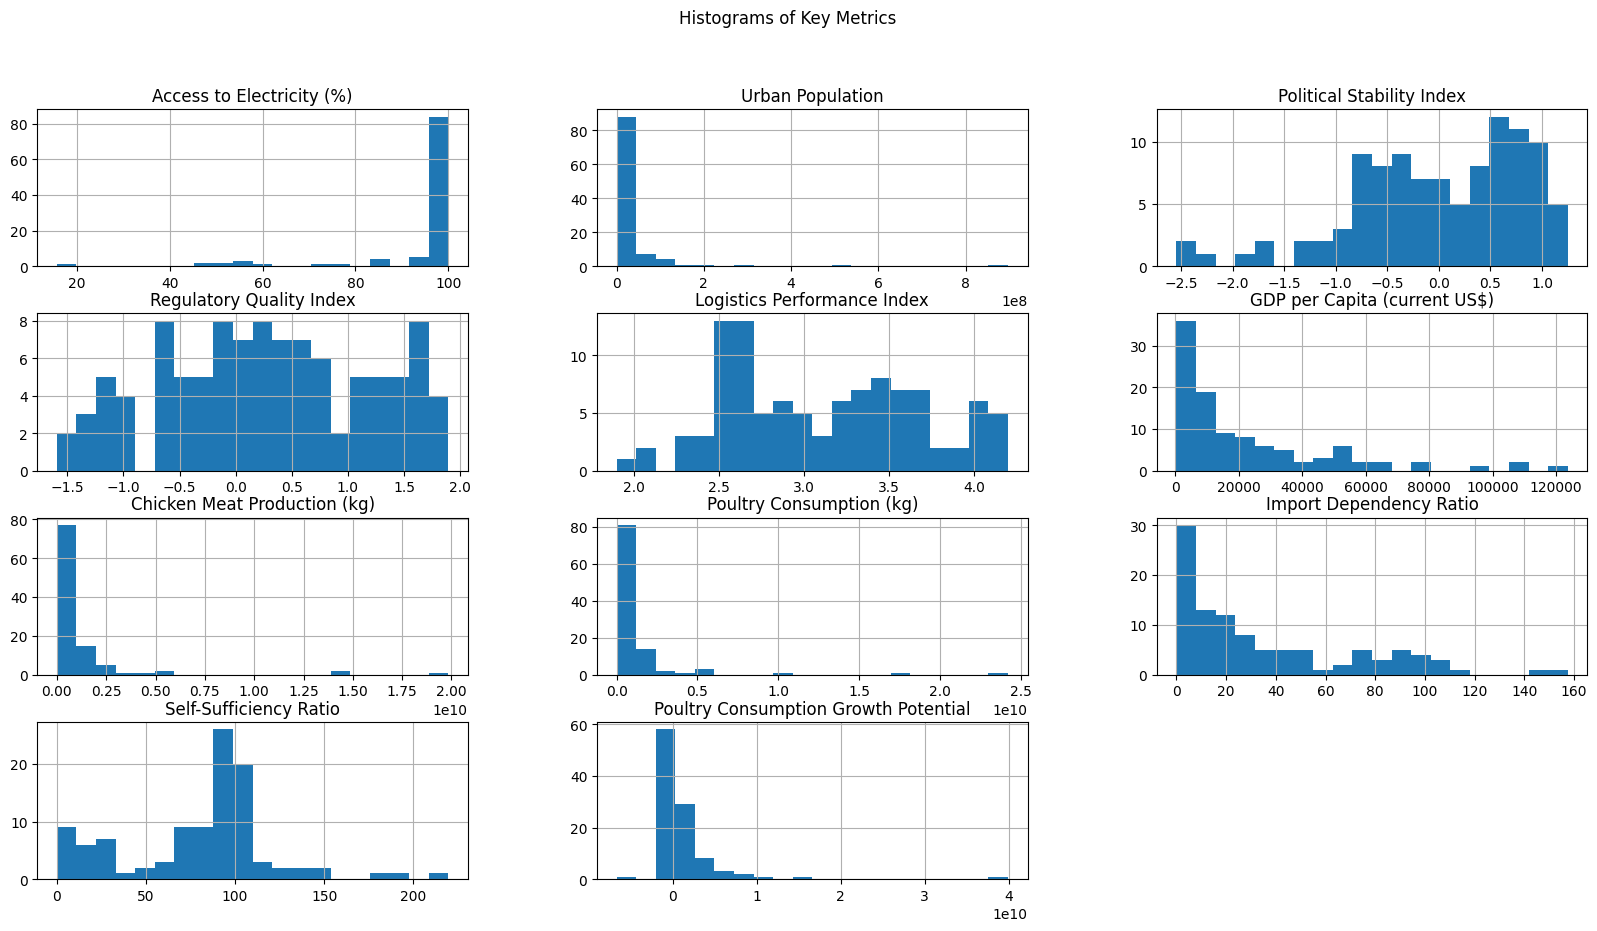

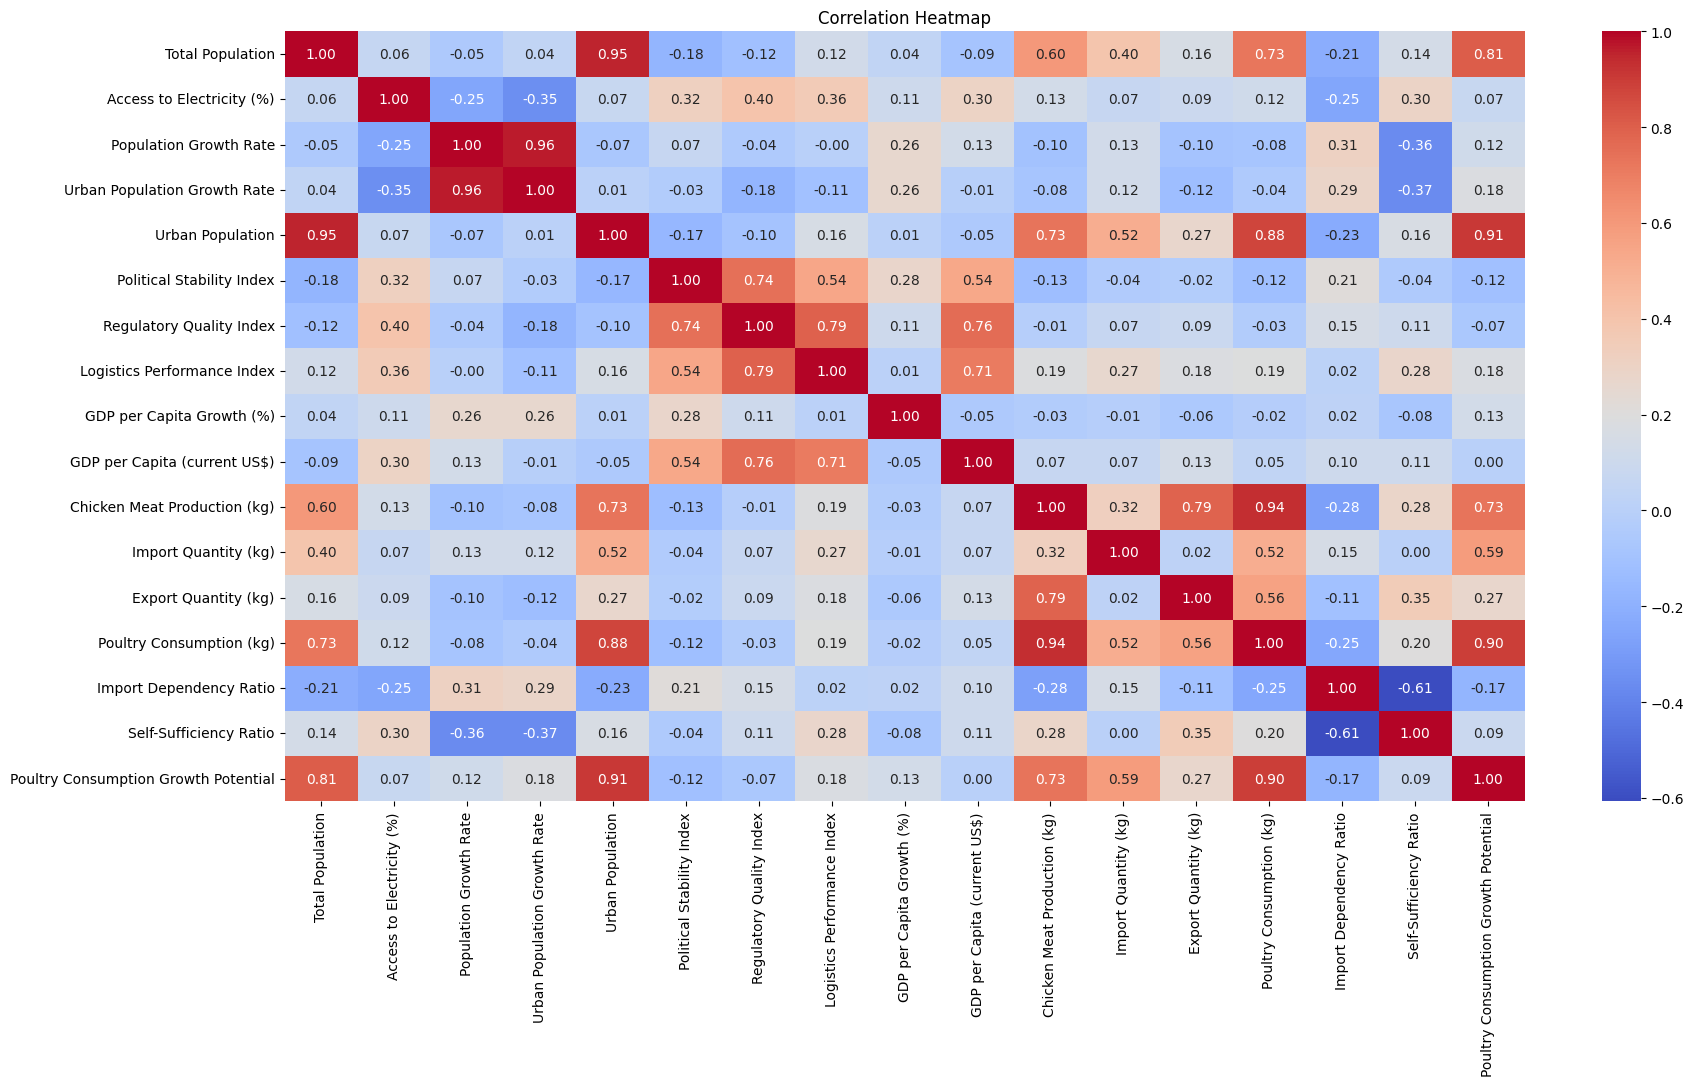

In [46]:
key_metrics = [
       'Access to Electricity (%)', 
       'Urban Population',
       'Political Stability Index', 'Regulatory Quality Index',
       'Logistics Performance Index',
       'GDP per Capita (current US$)', 'Chicken Meat Production (kg)',
       'Poultry Consumption (kg)', 'Import Dependency Ratio',
       'Self-Sufficiency Ratio', 'Poultry Consumption Growth Potential'
]

# Histograms
df_all[key_metrics].hist(bins=20, figsize=(20, 10))
plt.suptitle('Histograms of Key Metrics')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(20, 10))
numeric_df = df_all.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Analyse des meilleurs et pires

In [ ]:
def plot_top_bottom(df, column, title_prefix, n=10, palette='viridis'):
    """Tracer les top et bottom n pays pour une métrique donnée"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top n
    top = df.nlargest(n, column)[['Country Code', column]].set_index('Country Code')
    sns.barplot(x=top.index, y=top[column], palette='Blues_r', ax=axes[0])
    axes[0].set_title(f'Top {n} {title_prefix}')
    axes[0].set_xlabel('Code de pays')
    axes[0].set_ylabel(column)
    axes[0].tick_params(axis='x', rotation=0)
    
    # Bottom n
    bottom = df.nsmallest(n, column)[['Country Code', column]].set_index('Country Code')
    sns.barplot(x=bottom.index, y=bottom[column], palette='Reds_r', ax=axes[1])
    axes[1].set_title(f'Bottom {n} {title_prefix}')
    axes[1].set_xlabel('Code de pays')
    axes[1].set_ylabel(column)
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return top, bottom

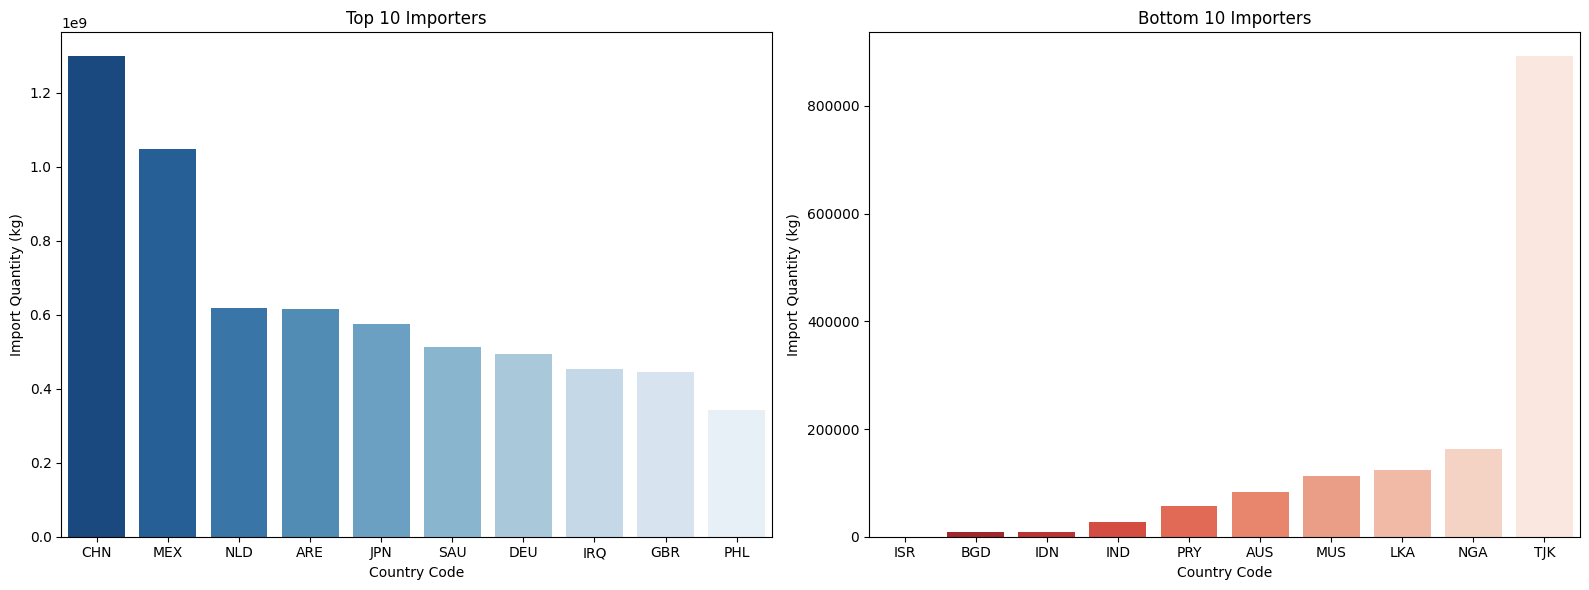


Top importer: CHN (1,298,211,070 kg)
Bottom importer: ISR (0 kg)


In [ ]:
top_imp, bottom_imp = plot_top_bottom(df_all, 'Import Quantity (kg)', 'Importateurs', palette='Blues_r')
print(f"\nPrincipal importateur: {top_imp.index[0]} ({top_imp.iloc[0, 0]:,.0f} kg)")
print(f"Plus petit importateur: {bottom_imp.index[0]} ({bottom_imp.iloc[0, 0]:,.0f} kg)")

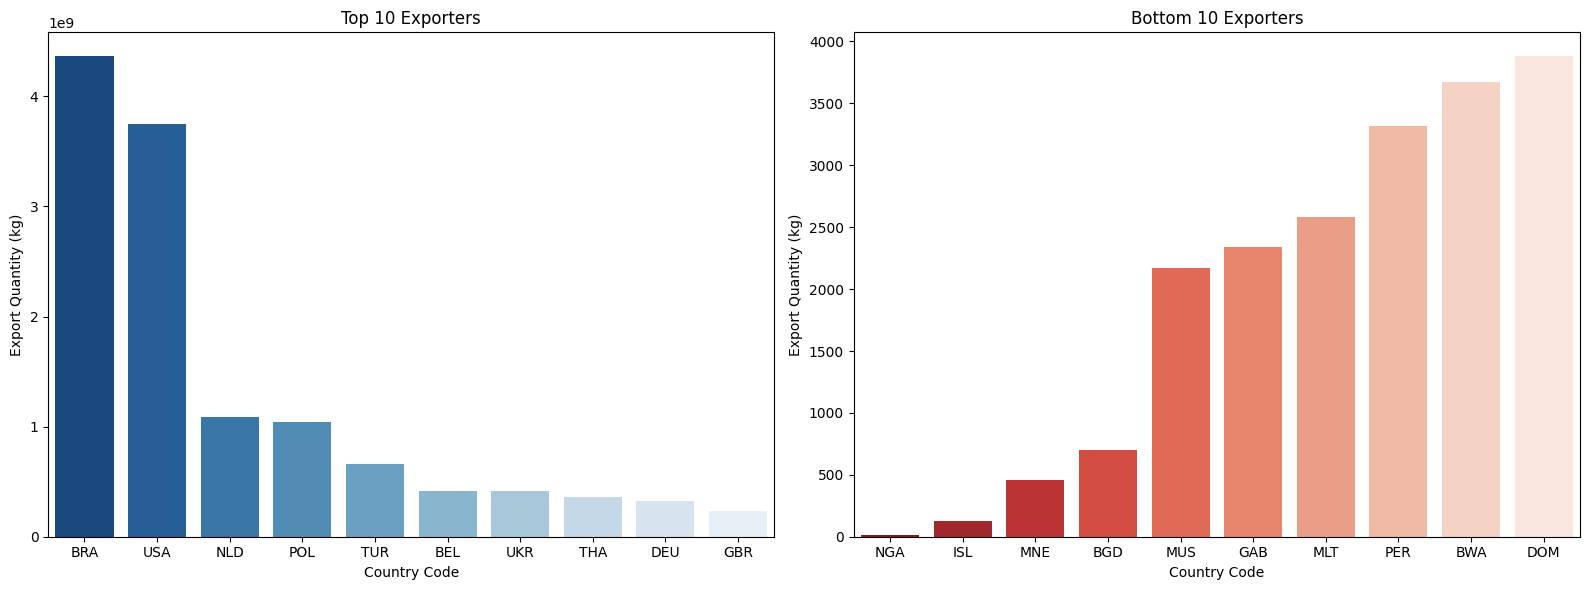


Top exporter: BRA (4,364,053,230 kg)
Bottom exporter: NGA (10 kg)


In [ ]:
# Analyse des exportations
top_exp, bottom_exp = plot_top_bottom(df_all, 'Export Quantity (kg)', 'Exportateurs', palette='Greens_r')
print(f"\nPrincipal exportateur: {top_exp.index[0]} ({top_exp.iloc[0, 0]:,.0f} kg)")
print(f"Plus petit exportateur: {bottom_exp.index[0]} ({bottom_exp.iloc[0, 0]:,.0f} kg)")

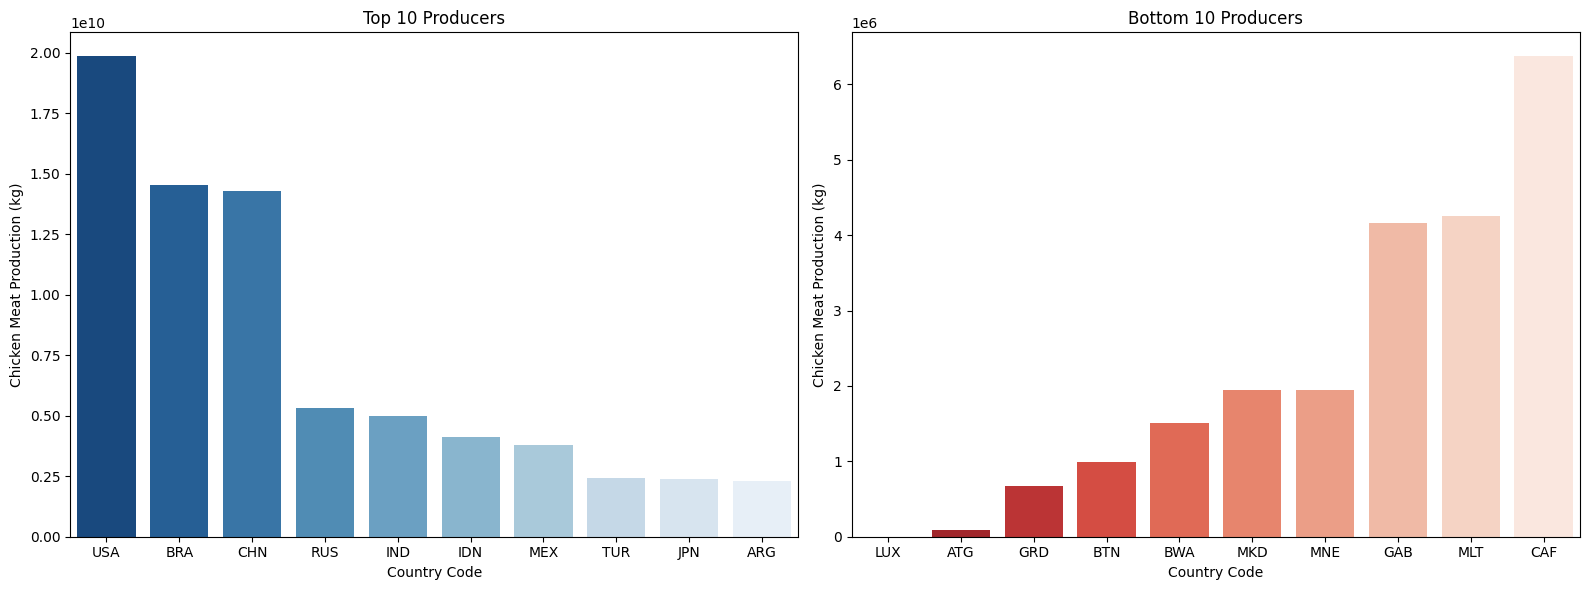


Top producer: USA (19,841,240,000 kg)
Bottom producer: LUX (0 kg)


In [ ]:
## Analyse de la production
top_prod, bottom_prod = plot_top_bottom(df_all, 'Chicken Meat Production (kg)', 
                                         'Producteurs', palette='YlOrRd')
print(f"\nPrincipal producteur: {top_prod.index[0]} ({top_prod.iloc[0, 0]:,.0f} kg)")
print(f"Plus petit producteur: {bottom_prod.index[0]} ({bottom_prod.iloc[0, 0]:,.0f} kg)")

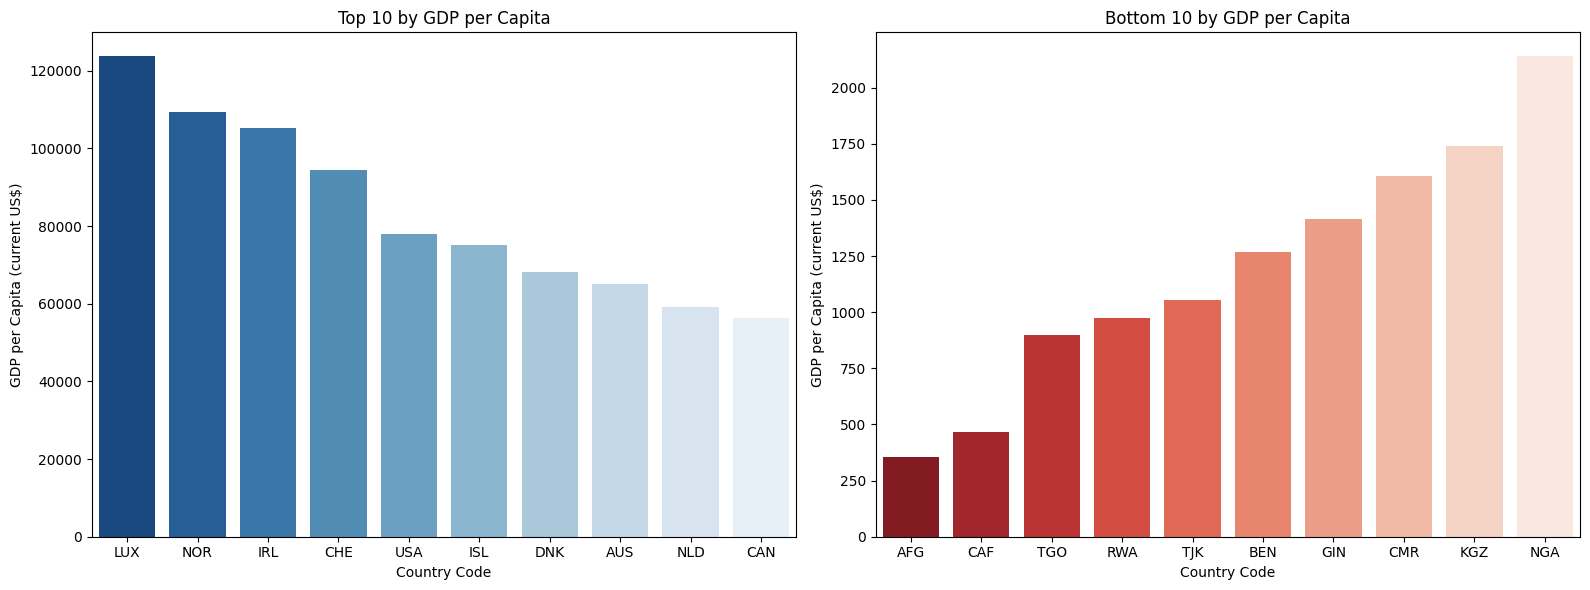


Highest GDP per capita: LUX ($123,719.66)
Lowest GDP per capita: AFG ($357.26)
Average GDP per capita: $22,253.01


In [ ]:
# PIB
top_gdp, bottom_gdp = plot_top_bottom(df_all, 'GDP per Capita (current US$)', 
                                       'par PIB par habitant', palette='RdYlGn')
print(f"\nPIB par habitant le plus élevé: {top_gdp.index[0]} (${top_gdp.iloc[0, 0]:,.2f})")
print(f"PIB par habitant le plus bas: {bottom_gdp.index[0]} (${bottom_gdp.iloc[0, 0]:,.2f})")
print(f"PIB par habitant moyen: ${df_all['GDP per Capita (current US$)'].mean():,.2f}")

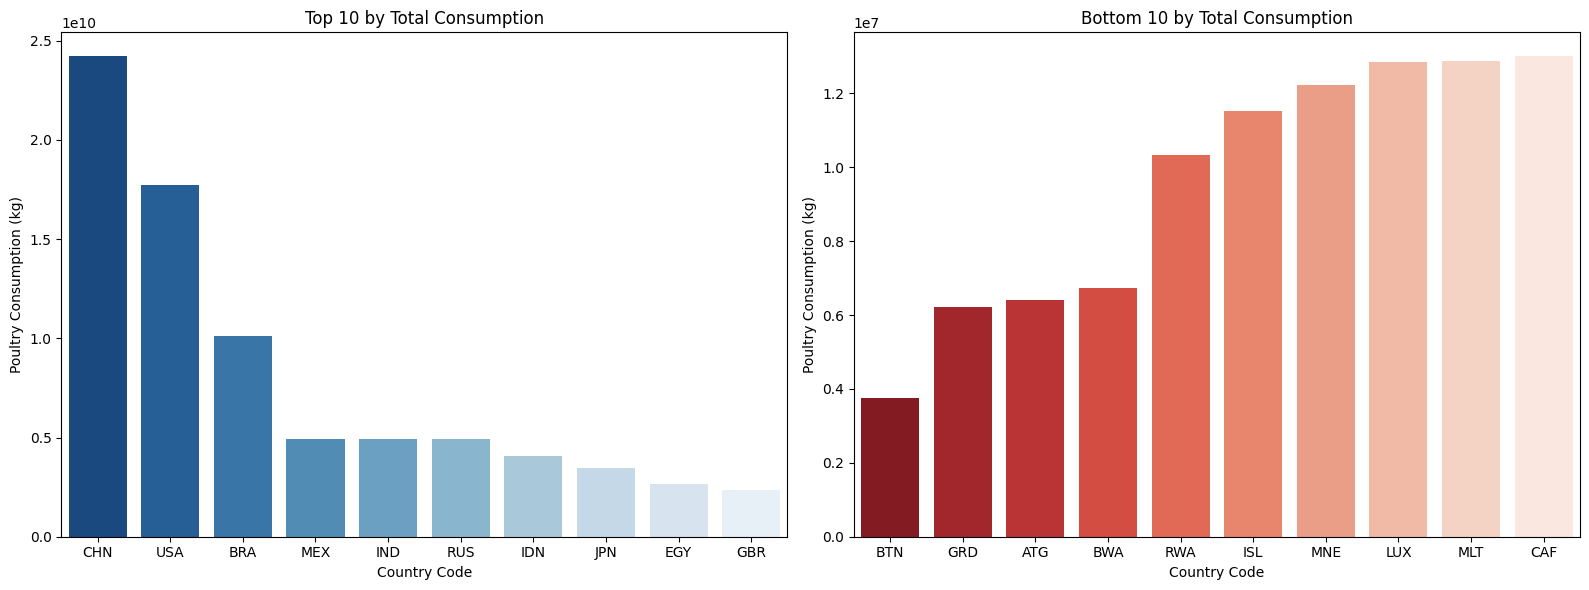


Total global consumption: 120,233,818,130 kg


In [ ]:
# Consommation totale
top_cons_total, _ = plot_top_bottom(df_all, 'Poultry Consumption (kg)', 
                                     'par consommation totale', n=10, palette='plasma')
print(f"\nConsommation mondiale totale: {df_all['Poultry Consumption (kg)'].sum():,.0f} kg")

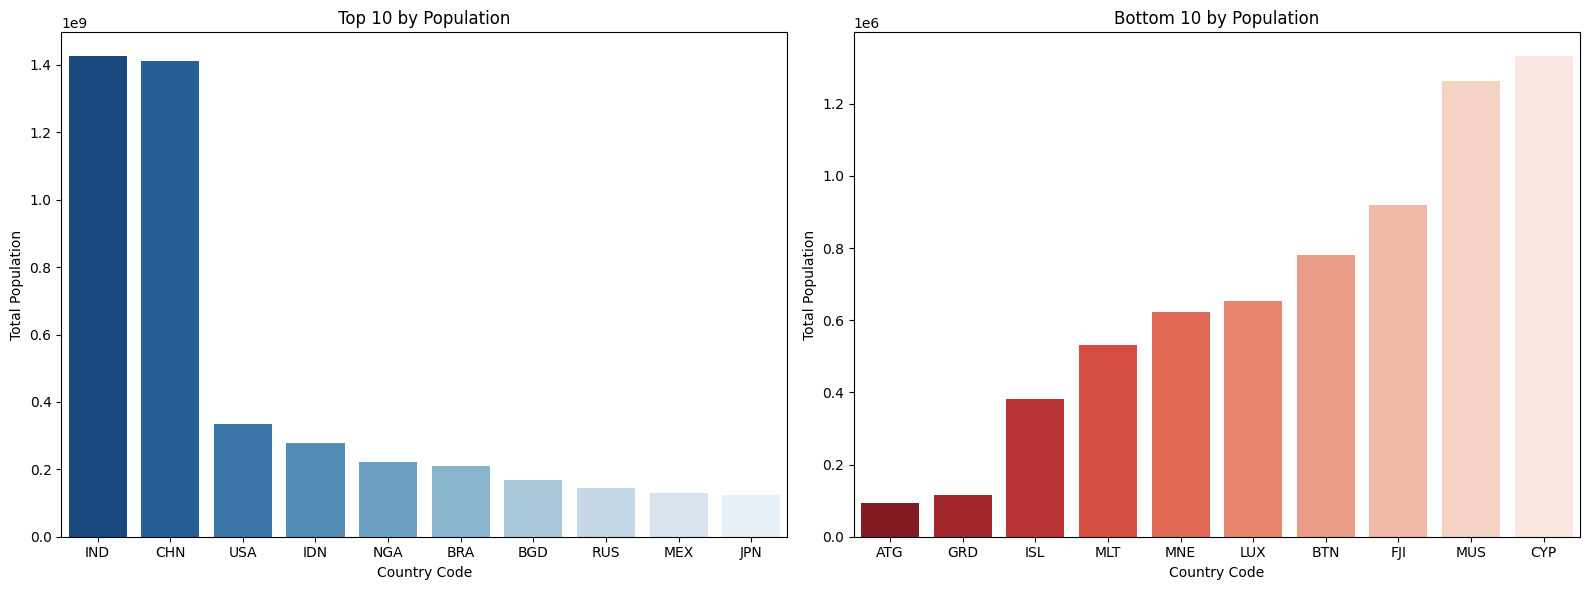


Largest population: IND (1,425,423,212)


In [ ]:
# Population totale
top_pop, _ = plot_top_bottom(df_all, 'Total Population', 'par population', palette='viridis')
print(f"\nPopulation la plus grande: {top_pop.index[0]} ({top_pop.iloc[0, 0]:,.0f})")

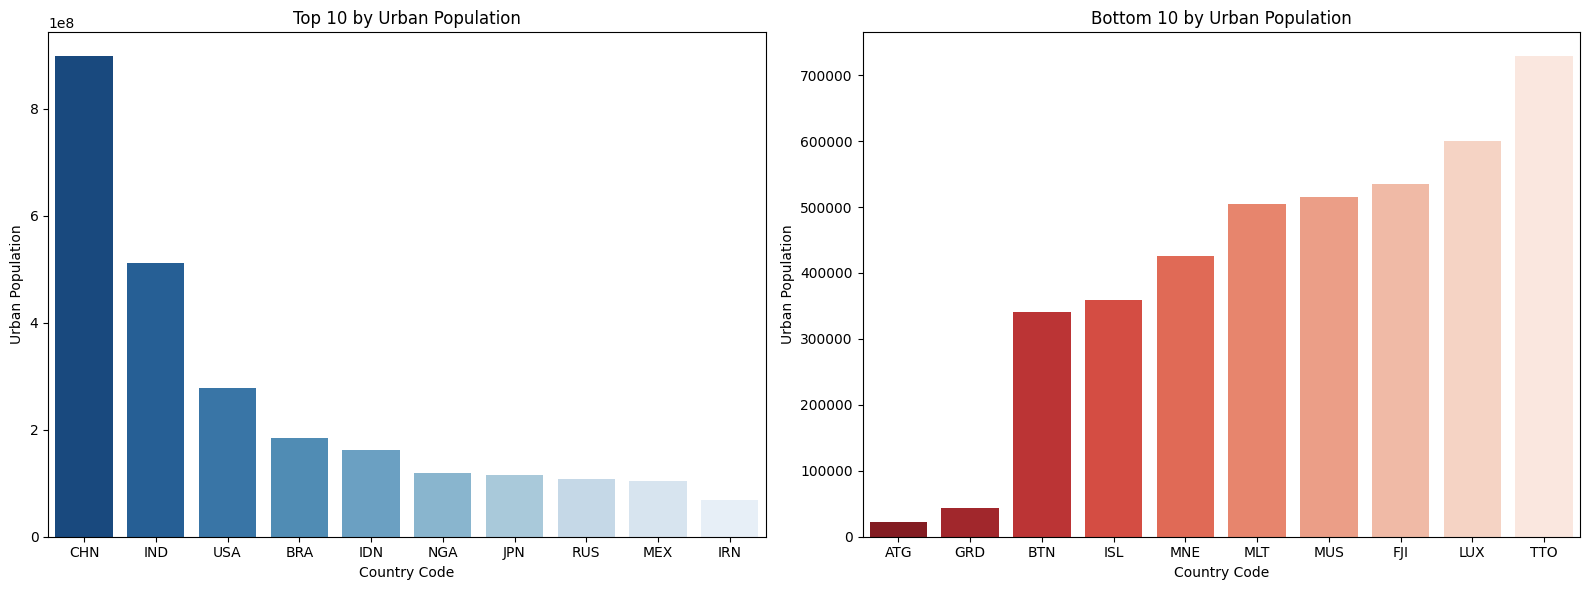


Largest urban population: CHN (897,578,430)


In [ ]:
# Population urbaine
top_urban, _ = plot_top_bottom(df_all, 'Urban Population', 'par population urbaine', palette='cividis')
print(f"\nPopulation urbaine la plus grande: {top_urban.index[0]} ({top_urban.iloc[0, 0]:,.0f})")

## 6. Résumé

Ce carnet effectue une préparation des données complète et une analyse exploratoire pour une étude de marché du poulet mondial utilisant des données de 2022. L'analyse intègre les données de la Banque mondiale, de la FAO et des sources des Nations Unies pour créer un ensemble de données unifié pour les informations sur le marché.

### Étapes clés:
- **Chargement des données**: Intégration de 16+ ensembles de données couvrant la production, la consommation, le commerce et les indicateurs économiques
- **Ingénierie des caractéristiques**: Création de trois métriques clés:
  - Ratio de dépendance aux importations: Mesure la dépendance vis-à-vis des importations
  - Ratio d'autosuffisance: Mesure la capacité de production domestique
  - Potentiel de croissance de la consommation de volaille: Combine la consommation avec les tendances d'urbanisation
- **Analyse des anomalies**: Identification de 6 anomalies stratégiques (États-Unis, Chine, Inde, Brésil, Pays-Bas, Luxembourg) retenues pour les informations sur le marché en raison de leur importance stratégique
- **Exploration des données**: Analyse des distributions, corrélations et des meilleurs/pires performers pour la production, la consommation, les importations, les exportations et les indicateurs économiques

### Production:
- Ensemble de données nettoyé sauvegardé dans `cleaned_chicken_market_study_data.csv`
- 104 pays analysés avec 10+ caractéristiques
- Prêt pour l'analyse de clustering et la segmentation du marché